In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
from connector import spark_connector

In [3]:
import pandas as pd
import numpy as np
from pyspark.sql import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [4]:
spark_connector?

Init signature:
spark_connector(
    exec_inst: int = 100,
    exec_cores: int = 5,
    aloc_max: int = 500,
    memory_exec: int = 25,
    name: object = 'utopialvo',
    rootdir: object = 'remote_dir_in_hdft',
    enable_graphframes: bool = False,
    enable_clickhouse: bool = False,
    enable_postgres: bool = False,
    dynamic_allocation: bool = False,
    intensive_mode: bool = False,
    marshal_mode: bool = True,
    yarn: bool = True,
) -> None
Docstring:     
Класс стандартного подключения к Spark

exec_inst - количество контейнеров
exec_cores - количество ядер в контейнере
aloc_max - максимальное количество ядер для dynamic_allocation (если он вкл)
memory_exec - количество памяти в контейнере
name - название подключения для упрощения логгирования подключений в кластере
rootdir - корневая папка в HDFS 
enable_graphframes - включить работу с graphframes
enable_clickhouse - включить работу с clickhouse
enable_postgres - включить работу с postgres
dynamic_allocation - включить д

In [5]:
con = spark_connector(exec_inst=100, exec_cores=5, memory_exec=25, enable_graphframes=True, marshal_mode=False, yarn = False)

In [6]:
con.spark

In [7]:
#con.stop_spark()

In [8]:
from sklearn.datasets import make_blobs

In [9]:
X, y, c = make_blobs(n_samples=3000, n_features=2, centers=24, cluster_std=2.0, center_box=(-150.0, 15.0), shuffle=True, random_state=0, return_centers=True)

In [10]:
data = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(X.shape[1])])
data['y'] = y
data = data.merge(pd.DataFrame(c, columns=[f'centroids_{i+1}' for i in range(X.shape[1])]).reset_index(), left_on='y', right_on='index', how='left').drop('index', axis=1)

In [11]:
data

,x1,x2,y,centroids_1,centroids_2
0,-77.318945,-3.597057,3,-77.798110,-2.857455
1,12.817300,-17.619172,10,11.472026,-18.138837
2,-149.464477,-12.268365,8,-146.663964,-12.617725
3,-122.328270,4.890742,13,-126.346708,5.870371
4,-131.024482,-41.878770,12,-130.484720,-44.413031
...,...,...,...,...,...
2995,-46.320679,-48.416270,18,-49.004206,-48.205891
2996,-110.356084,-129.900276,23,-115.286877,-128.727161
2997,-135.168822,-134.397013,7,-138.279050,-135.623666
2998,-75.226099,-22.631728,11,-73.855905,-21.212686


In [12]:
import seaborn as sns

<Axes: xlabel='x1', ylabel='x2'>

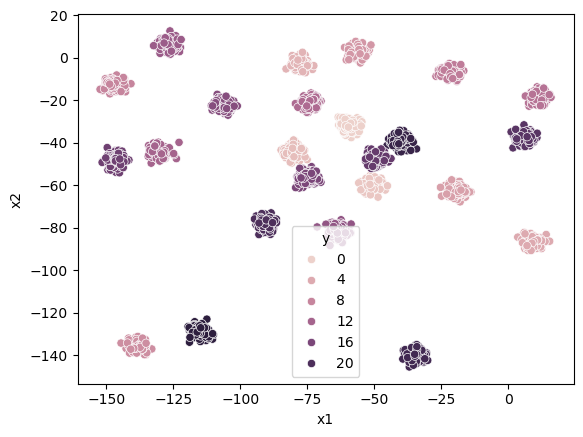

In [13]:
sns.scatterplot(x=data.x1, y=data.x2, hue=data.y)

In [14]:
data2 = data.reset_index(names='index_train').drop(['y','centroids_1','centroids_2'], axis=1)

In [15]:
data2

,index_train,x1,x2
0,0,-77.318945,-3.597057
1,1,12.817300,-17.619172
2,2,-149.464477,-12.268365
3,3,-122.328270,4.890742
4,4,-131.024482,-41.878770
...,...,...,...
2995,2995,-46.320679,-48.416270
2996,2996,-110.356084,-129.900276
2997,2997,-135.168822,-134.397013
2998,2998,-75.226099,-22.631728


In [16]:
train_df = con.spark.createDataFrame(data2)

# HiClust

In [17]:
from HiClust import HiClust

In [18]:
HiClust?

Init signature:
HiClust(
    spark: pyspark.sql.session.SparkSession,
    train_df: pyspark.sql.dataframe.DataFrame,
    window_size=None,
    idcol: str = 'index_train',
) -> None
Docstring:      Кастомная иерархическая кластеризация
Init docstring:
Предобработка датасета для кластеризации.
window_size - количество строк в партиции. Если не задано, подсчет происходит автоматически.
Желательно нормализовать все столбцы кроме idcol. 
В объект следует передавать только фичи, по которым должна происходить кластеризация.
File:           ~/work/Spark_conn/src/HiClust.py
Type:           type
Subclasses:     

In [42]:
clust = HiClust(con.spark, train_df=train_df, idcol= 'index_train')

In [43]:
clust.fit?

Signature:
clust.fit(
    metric: str = 'euclidean',
    distance_threshold: float = 0.1,
    max_iterations: int = 10,
    auto_threshold: bool = False,
    find_top_one: bool = False,
) -> None
Docstring: <no docstring>
File:      ~/work/Spark_conn/src/HiClust.py
Type:      method

In [44]:
clust.fit(metric = 'euclidean', distance_threshold = 0.23, max_iterations = 20, auto_threshold=False, find_top_one=False)

iteration: 1, count clusters = 2475
iteration: 2, count clusters = 2288
iteration: 3, count clusters = 2127
iteration: 4, count clusters = 1830
iteration: 5, count clusters = 1428
iteration: 6, count clusters = 988
iteration: 7, count clusters = 476
iteration: 8, count clusters = 136
iteration: 9, count clusters = 26
iteration: 10, count clusters = 22
iteration: 11, count clusters = 19
All distances exceed threshold 0.23


In [58]:
pred = clust.get_clusters(11).toPandas()

In [59]:
pred = data.reset_index(names='index_train')[['index_train','y']].merge(pred, on='index_train', how='left')

In [60]:
pred

,index_train,y,cluster_id_11
0,0,3,30651
1,1,10,23957
2,2,8,30653
3,3,13,30654
4,4,12,30655
...,...,...,...
2995,2995,18,12058
2996,2996,23,15000
2997,2997,7,14998
2998,2998,11,4845


In [61]:
from sklearn.metrics.cluster import adjusted_rand_score

In [62]:
adjusted_rand_score(pred.y.tolist(), pred.cluster_id_11.tolist())

0.2693117883449802

In [63]:
#con.stop_spark()

time: 2025-02-22 22:36:06.316571
del
stop
